C:\Users\Stefan\AppData\Local\Temp\ipykernel_14716\646925699.py:65: ComplexWarning: Casting complex values to real discards the imaginary part
  TotalEnergy[i] = np.vdot(data[:,i],data[:,i])*abs(x[1]-x[0])/2


(Text(0.5, 1.0, 'Total Energy'), None, (0.0, 1.0))

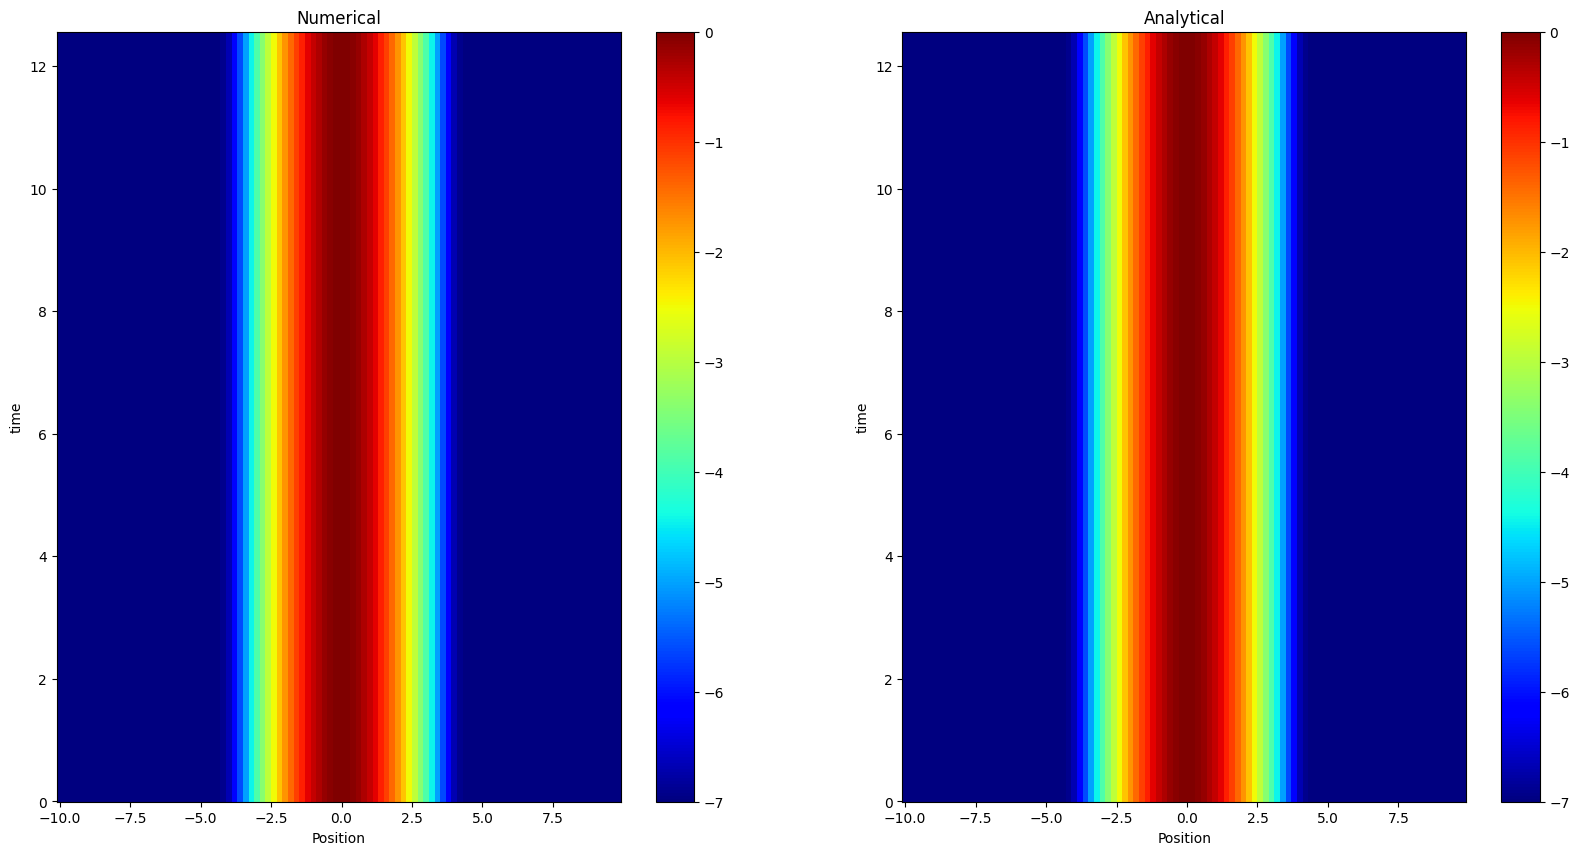

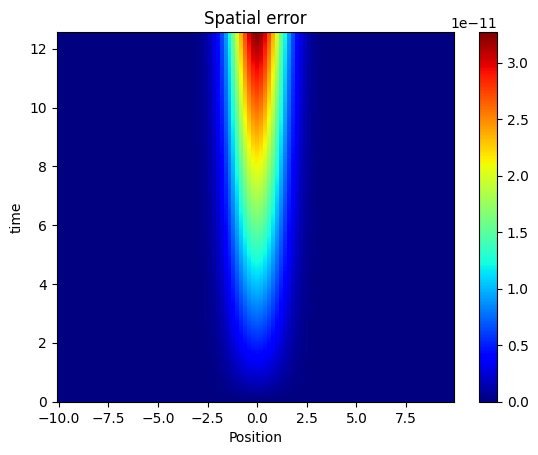

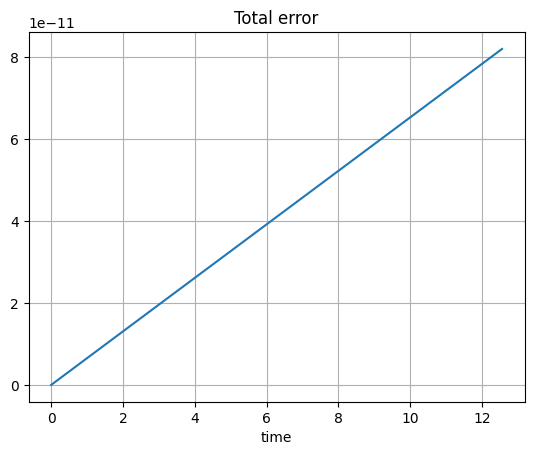

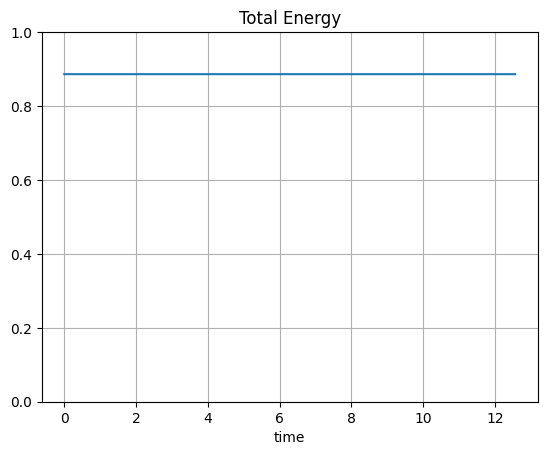

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import cmath as cm
px = 1/plt.rcParams['figure.dpi']

def RungeKutta(t,interval,func,initial):
    dt = abs(t[2]-t[1]);
    df = np.zeros([np.size(initial),np.size(t)],'complex');
    df[:,0] = initial;
    for i in range(np.size(t)-1):
        k1 = func(df[:,i],interval)
        k2 = func(df[:,i]+dt/2*k1,interval)
        k3 = func(df[:,i]+dt*k2/2,interval)
        k4 = func(df[:,i]+dt*k3,interval)
        df[:,i+1] = df[:,i] + 1/6*(k1+2*k2+2*k3+k4)*dt
    return df

def FourierDerivative(func,interval,ndif):
    k0 = 2*np.pi/(interval[1]-interval[0])
    L = int(np.size(func)/2)
    m = np.concatenate([np.linspace(0,L-1,L),np.linspace(-L,-1,L)])
    for i in range(ndif):
        func = np.fft.ifft(1j*m*k0*np.fft.fft(func))
        i = i+1
        # if np.imag(func) > 1:
        #     print("Warning: Imaginary part is grater than 1")
    return func

def Hamiltonian(func,interval):
    x = np.linspace(interval[0],interval[1], np.size(func)+1)
    x = x[:-1]
    return -1j*0.5*(-FourierDerivative(func,interval,2)+x**2*func) 

# def GetSchroedingerSlope(func,interval):
#     return -1j*Hamiltonian(func,interval)

L = 20; # Length of interval
N = 100; # Points of discretization
tmax = 4*np.pi; # endtime
dt = 1/N; # Time step

x = np.linspace(-L/2,L/2, N+1) # Due to periodicty (Fourier) the last value cant be used
x = x[:-1]

t = np.arange(0,tmax,dt) # time grid

X,T = np.meshgrid(x,t) # Only used fot plotting

# Analytical solution
analytical = np.exp(-0.5*x**2).reshape(np.size(x),1)*np.exp(-1j*0.5*t).reshape(1,np.size(t)) 

# Initialize
initial = np.exp(-0.5*x**2) 

# Compute
data = RungeKutta(t,[-L/2,L/2],Hamiltonian,initial)

# Errors and Energy
SpatialError = abs(data - analytical); # Absolute difference between numerical and analytical
TotalError = np.sum(SpatialError,axis=0)*L/N # Sum over all x values at each timestep, L1 norm
TotalEnergy = np.zeros([len(t)]) # The expectation value of the Hamuiltonian is the total energy, which can be obtained by an inner product
for i in range(len(t)):
    # TotalEnergy[i] = np.inner(np.conj(data[:,i]),data[:,i])*abs(x[1]-x[0])/2
    TotalEnergy[i] = np.vdot(data[:,i],data[:,i])*abs(x[1]-x[0])/2

# Plotting, where division by zero is avoided by adding 1e-7
fig = plt.figure(figsize=(2000*px, 1000*px));
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Numerical')
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Analytical')
colormesh1 = ax1.pcolormesh(X,T,np.log10(abs(np.transpose(data))**2+1e-7),shading='auto',cmap='jet')
colormesh2 = ax2.pcolormesh(X,T,np.log10(abs(np.transpose(analytical))**2+1e-7),shading='auto',cmap='jet')
fig.colorbar(colormesh1,ax=ax1),ax1.set_xlabel('Position'),ax1.set_ylabel('time')
fig.colorbar(colormesh2,ax=ax2),ax2.set_xlabel('Position'),ax2.set_ylabel('time')


fig2 = plt.figure()
ax = fig2.add_subplot(1,1,1)
colormesh3 = ax.pcolormesh(X,T,np.transpose(SpatialError),shading='auto',cmap='jet')
ax.set_title('Spatial error'),ax.set_xlabel('Position'),ax.set_ylabel('time')
fig2.colorbar(colormesh3,ax=ax)

fig3 = plt.figure()
ax = fig3.add_subplot(1,1,1)
ax.plot(t,TotalError),ax.set_xlabel('time')
ax.set_title('Total error'),ax.grid()

fig4 = plt.figure()
ax = fig4.add_subplot(1,1,1)
ax.plot(t,TotalEnergy),ax.set_xlabel('time')
ax.set_title('Total Energy'),ax.grid(),ax.set_ylim([0,1])


(<matplotlib.colorbar.Colorbar at 0x20bd65f4310>,
 Text(0.5, 0, 'Position'),
 Text(0, 0.5, 'time'))

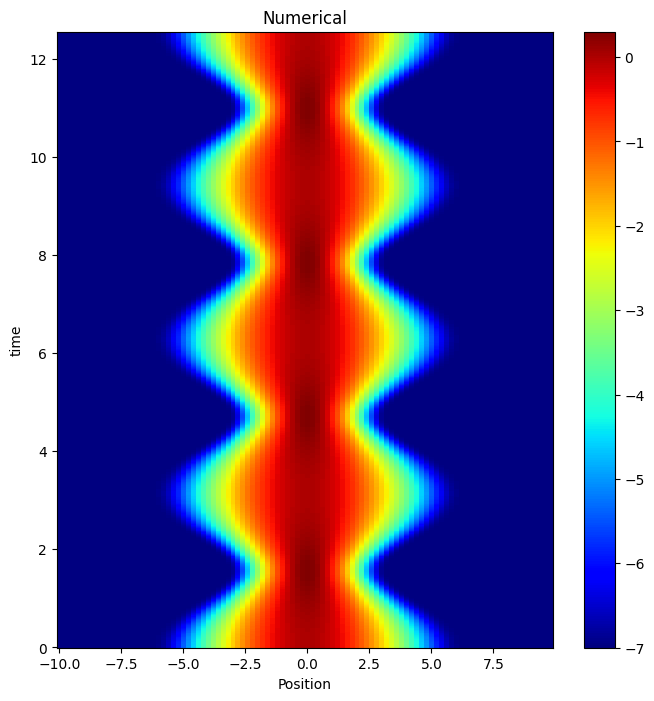

In [137]:
# Initialize
initial = np.exp(-0.25*x**2) 
# initial = np.exp(-0.25*(x-4)**2)
# initial = np.exp(-0.5*(x-4)**2) # Pumping 
# initial = np.exp(-2*(x-4)**2)
# initial = np.exp(-2*(x-4)**2)-np.exp(-2*(x+4)**2)
# initial = np.exp(-2*(x-4)**2)-np.exp(-0.25*(x+4)**2) # Two wavefunctions interfere
# initial = np.exp(-2*(x-4)**2)+np.exp(-2*(x+4)**2)

data = RungeKutta(t,[-L/2,L/2],Hamiltonian,initial)

fig = plt.figure(figsize=(800*px, 800*px));
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Numerical')
colormesh1 = ax1.pcolormesh(X,T,np.log10(abs(np.transpose(data))**2+1e-7),shading='auto',cmap='jet')
fig.colorbar(colormesh1,ax=ax1),ax1.set_xlabel('Position'),ax1.set_ylabel('time')

([<matplotlib.lines.Line2D at 0x1dce14f6250>],
 Text(0, 0.5, 'log(MaxError)'),
 Text(0.5, 0, 'log(N)'),
 Text(0.5, 1.0, '$L_\\infty$ norm'),
 None)

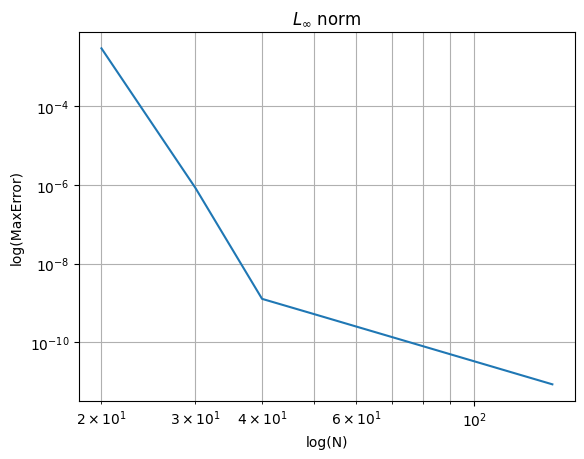

In [18]:
# Convergence analysis
N = np.arange(20,150,10); # Time step
MaxError = np.linspace(0,1,len(N))

for i in range(len(N)):
    dt = 1/N[i]; # Time step
    x = np.linspace(-L/2,L/2, N[i]+1) # Due to periodicty (Fourier) the last value cant be used
    x = x[:-1]
    t = np.arange(0,tmax,dt) # time grid
    initial = np.exp(-0.5*x**2) 
    data = RungeKutta(t,[-L/2,L/2],Hamiltonian,initial)
    analytical = np.exp(-0.5*x**2).reshape(np.size(x),1)*np.exp(-1j*0.5*t).reshape(1,np.size(t)) 
    SpatialError = abs(data - analytical); # Absolute difference between numerical and analytical
    TotalError = np.max(SpatialError,axis=0) # Sum over all x values at each timestep, L1 norm
    MaxError[i] = np.max(TotalError); # L infinity norm

plt.loglog(N,MaxError),plt.ylabel('log(MaxError)'),plt.xlabel('log(N)'),plt.title('$L_\infty$ norm'),plt.grid(which='both',axis='both')